#Supply Chain Resilience through IoT Visibility

###1. IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

###2. LOAD DATASET

In [30]:
df = pd.read_excel('IoT_Agriculture_2024.xlsx')

print("Initial Data Preview:")
print(df.head())

Initial Data Preview:
                 date  temperature  humidity  water_level    N    P    K  \
0 2024-02-08 06:10:00           41        63          100  255  255  255   
1 2024-02-08 06:15:00           41        59          100  255  255  255   
2 2024-02-08 06:20:00           41        62          100  255  255  255   
3 2024-02-08 06:05:00           40        60          100  255  255  255   
4 2024-02-08 06:00:00           39        61          100  255  255  255   

   Fan_actuator_OFF  Fan_actuator_ON  Watering_plant_pump_OFF  \
0                 0                1                        1   
1                 0                1                        1   
2                 0                1                        1   
3                 0                1                        1   
4                 0                1                        1   

   Watering_plant_pump_ON  Water_pump_actuator_OFF  Water_pump_actuator_ON  
0                       0                        1   

###3. BASIC DATA CLEANING

In [31]:
df = df.dropna()

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Sort by time
df = df.sort_values('date')

# Remove duplicate timestamps
df = df.drop_duplicates(subset='date')

# Set date as index
df = df.set_index('date')

# Resample to 5 minutes properly
df = df.resample('5min').mean()

# Time-based interpolation (important)
df = df.interpolate(method='time')

# Remove any remaining missing rows
df = df.dropna()

print("\nCleaning complete.")
print(df.tail())


Cleaning complete.
                     temperature  humidity  water_level      N      P      K  \
date                                                                           
2024-03-30 05:00:00    35.965909       0.0          0.0  255.0  255.0  255.0   
2024-03-30 05:05:00    35.977273       0.0          0.0  255.0  255.0  255.0   
2024-03-30 05:10:00    35.988636       0.0          0.0  255.0  255.0  255.0   
2024-03-30 05:15:00    36.000000       0.0          0.0  255.0  255.0  255.0   
2024-03-30 05:20:00    33.600000       0.0          3.2  255.0  255.0  255.0   

                     Fan_actuator_OFF  Fan_actuator_ON  \
date                                                     
2024-03-30 05:00:00               0.0              1.0   
2024-03-30 05:05:00               0.0              1.0   
2024-03-30 05:10:00               0.0              1.0   
2024-03-30 05:15:00               0.0              1.0   
2024-03-30 05:20:00               0.0              1.0   

            

###4. FEATURE ENGINEERING

In [4]:
target_column = "temperature"

df["temp_diff"] = df[target_column].diff()
df["rolling_temp_mean"] = df[target_column].rolling(window=5).mean()

threshold = df[target_column].mean()
df["risk_label"] = (df[target_column] > threshold).astype(int)

df = df.dropna()

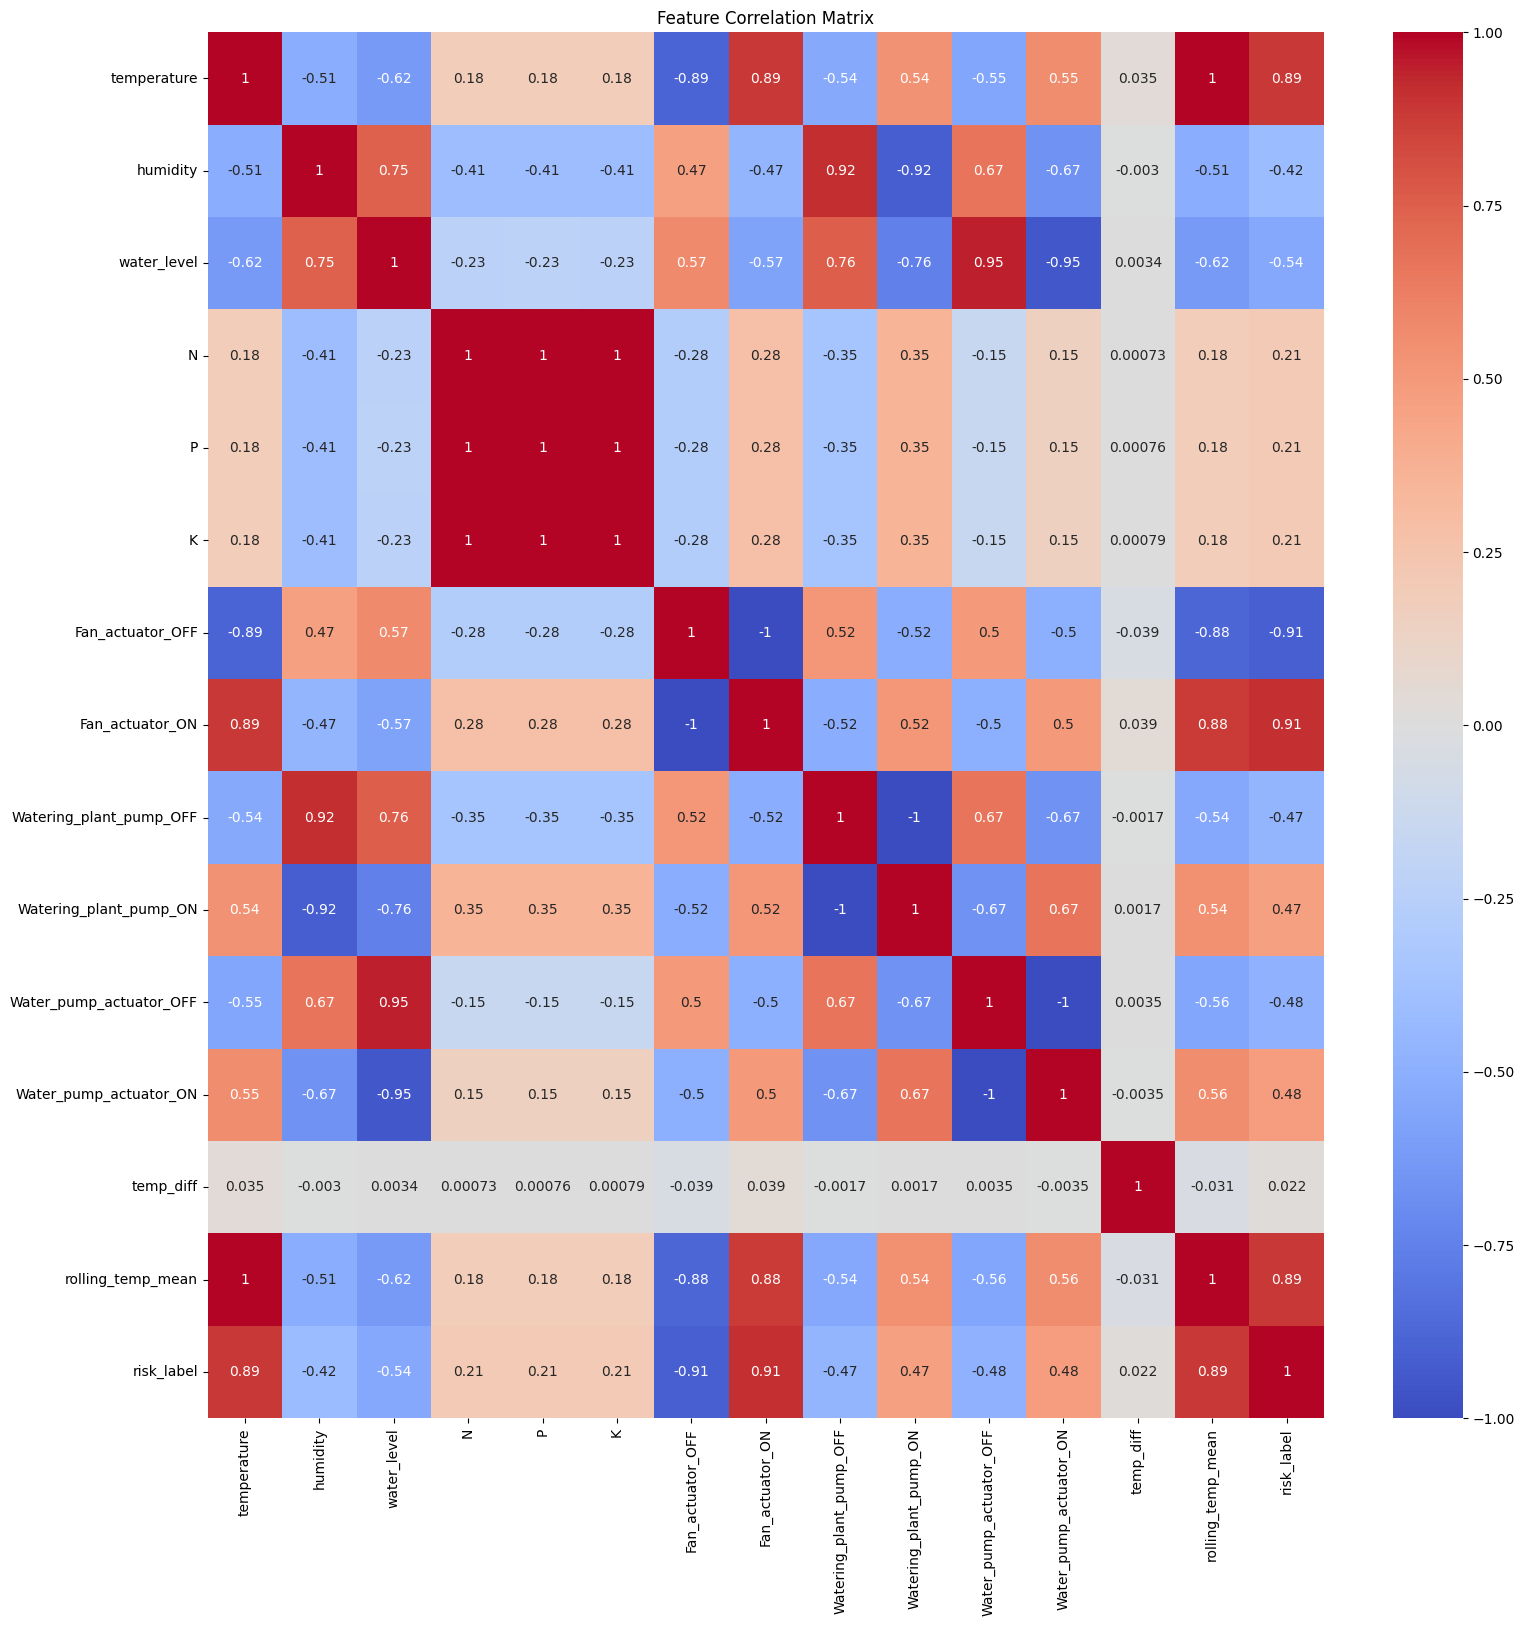

In [5]:
plt.figure(figsize=(18,18))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

###5. TRAIN / TEST SPLIT (Time Series Split)

In [6]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

###6. SCALING

In [7]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train[[target_column]])
test_scaled = scaler.transform(test[[target_column]])

###7. CREATE SEQUENCES FOR LSTM

In [8]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled)
X_test, y_test = create_sequences(test_scaled)

###8. LSTM MODEL (Deep Learning)

In [9]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(16, activation="relu"))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer="adam", loss="mse")

early_stop = EarlyStopping(patience=5)

lstm_model_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

lstm_pred = lstm_model.predict(X_test)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 0.0095 - val_loss: 8.9635e-04
Epoch 2/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - loss: 7.8597e-04 - val_loss: 3.6294e-04
Epoch 3/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 3.7969e-04 - val_loss: 2.6919e-04
Epoch 4/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 2.9267e-04 - val_loss: 7.4445e-04
Epoch 5/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - loss: 3.0351e-04 - val_loss: 2.3946e-04
Epoch 6/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 2.7636e-04 - val_loss: 2.3882e-04
Epoch 7/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - loss: 2.7946e-04 - val_loss: 2.4307e-04
Epoch 8/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - loss: 2.6943e-04 - val_loss: 3.1346e-04
Epoch 9/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - loss: 2.7368e-04 - val_loss: 3.0031e-04
Epoch 10/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 39s 53ms/step - loss: 2.6276e-04 - val_loss: 2.7296e-04
Epoch 11/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step

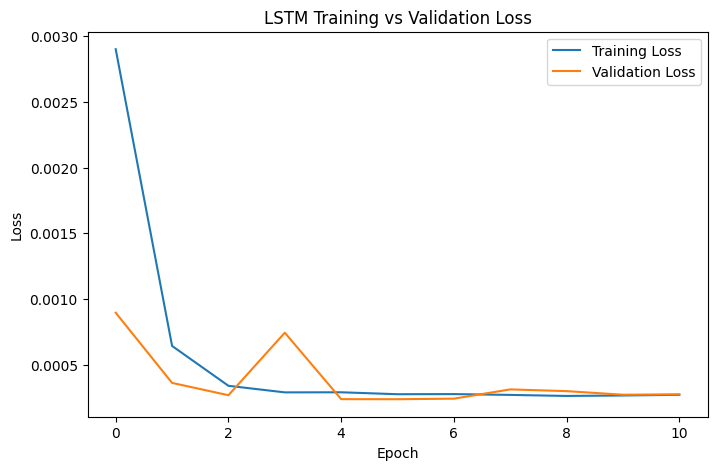

In [10]:
plt.figure(figsize=(8,5))
plt.plot(lstm_model_history.history['loss'], label='Training Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Validation Loss')
plt.title("LSTM Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

###9. SARIMA MODEL (Time Series)

In [11]:
sarima_model = SARIMAX(
    train[target_column],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

sarima_results = sarima_model.fit(disp=False)

sarima_forecast = sarima_results.forecast(steps=len(test))

###10. AUTOENCODER (Anomaly Detection)

In [12]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
decoded = Dense(input_dim, activation="sigmoid")(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.fit(
    X_train.reshape(X_train.shape[0], -1),
    X_train.reshape(X_train.shape[0], -1),
    epochs=20,
    batch_size=32,
    verbose=1
)

reconstructions = autoencoder.predict(
    X_test.reshape(X_test.shape[0], -1)
)

reconstruction_error = np.mean(
    np.power(X_test.reshape(X_test.shape[0], -1) - reconstructions, 2),
    axis=1
)

anomaly_threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > anomaly_threshold

print("\nNumber of detected anomalies:", np.sum(anomalies))

Epoch 1/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0236
Epoch 2/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0011
Epoch 3/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.8390e-04
Epoch 4/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7930e-04
Epoch 5/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.5137e-04
Epoch 6/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7309e-04
Epoch 7/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1255e-04
Epoch 8/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6930e-04
Epoch 9/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4458e-04
Epoch 10/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.2401e-04
Epoch 11/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.1022e-04
Epoch 12/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.0254e-04
Epoch 13/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9737e-04
Epoch 14/20
891/891 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9057e-04
Epoch 15/

###11. EVALUATION METRICS

In [13]:
# LSTM Metrics
# Convert predictions back to original scale
lstm_pred_inverse = scaler.inverse_transform(lstm_pred)

# Convert actual values back to original scale
y_test_inverse = scaler.inverse_transform(
    y_test.reshape(-1, 1)
)

# Calculate metrics properly
lstm_rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_pred_inverse))
lstm_mae = mean_absolute_error(y_test_inverse, lstm_pred_inverse)
lstm_r2 = r2_score(y_test_inverse, lstm_pred_inverse)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)
print("LSTM R2:", lstm_r2)

# SARIMA Metrics
sarima_rmse = np.sqrt(mean_squared_error(test[target_column], sarima_forecast))
sarima_mae = mean_absolute_error(test[target_column], sarima_forecast)
sarima_r2 = r2_score(test[target_column], sarima_forecast)

LSTM RMSE: 0.579314602124406
LSTM MAE: 0.5632249188985995
LSTM R2: 0.9478678391290126


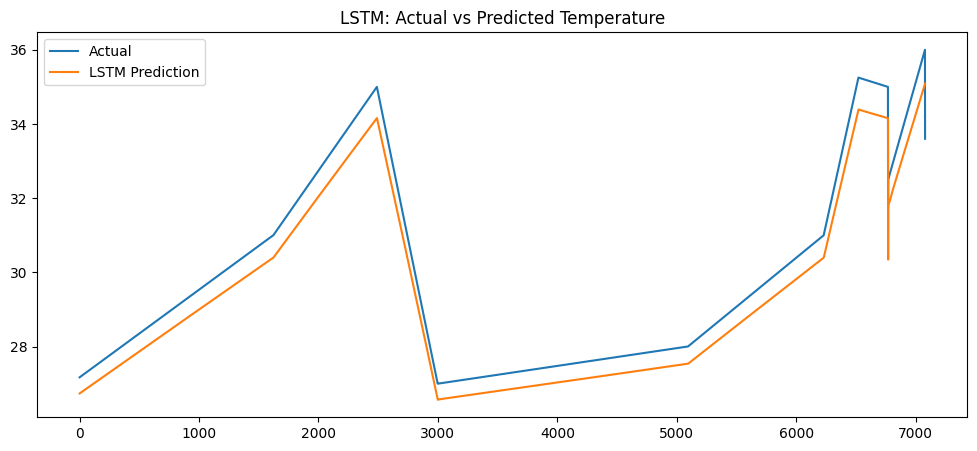

In [14]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inverse, label="Actual")
plt.plot(lstm_pred_inverse, label="LSTM Prediction")
plt.title("LSTM: Actual vs Predicted Temperature")
plt.legend()
plt.show()

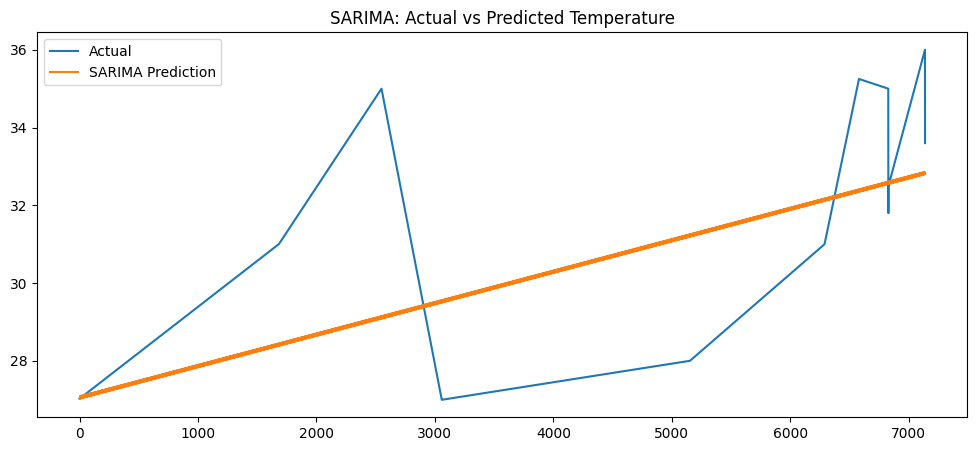

In [15]:
plt.figure(figsize=(12,5))
plt.plot(test[target_column].values, label="Actual")
plt.plot(sarima_forecast.values, label="SARIMA Prediction")
plt.title("SARIMA: Actual vs Predicted Temperature")
plt.legend()
plt.show()

###12. MODEL COMPARISON

In [16]:
comparison = pd.DataFrame({
    "Model": ["LSTM", "SARIMA"],
    "RMSE": [lstm_rmse, sarima_rmse],
    "MAE": [lstm_mae, sarima_mae],
    "R2": [lstm_r2, sarima_r2]
})

print("\nModel Comparison:")
print(comparison)


Model Comparison:
    Model      RMSE       MAE        R2
0    LSTM  0.579315  0.563225  0.947868
1  SARIMA  2.674799  2.388138 -0.109396


###13. RESILIENCE SCORE (IoT Business Insight)

In [17]:
df["resilience_score"] = 1 - (
    (df["risk_label"] * 0.5) +
    (np.concatenate([np.zeros(len(df) - len(anomalies)), anomalies.astype(int)]) * 0.5)
)

print("\nResilience Score Summary:")
print(df["resilience_score"].describe())


Resilience Score Summary:
count    35696.000000
mean         0.765660
std          0.259259
min          0.000000
25%          0.500000
50%          1.000000
75%          1.000000
max          1.000000
Name: resilience_score, dtype: float64


In [33]:
# Reset index so date becomes a column again
df_final = df.reset_index()

# Create empty prediction column
df_final['LSTM_Prediction'] = np.nan

# Assign predictions to last N rows properly
df_final.loc[df_final.index[-len(lstm_pred_inverse):], 'LSTM_Prediction'] = lstm_pred_inverse.flatten()

# Save to CSV
df_final.to_csv("IoT_Agriculture_Data_2024.csv", index=False)

print("File saved successfully.")

File saved successfully.
